In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

<h1> LIF neuron model </h1>
    <h3> In this session, the goal is to implement the LIF neuron model and investigate how it behaves by receiving different currents.</h3>
    <p>The currents that we will give as input to the neuron are:</p>
    <ul>
    <li>Linear current</li>
    <li>Sine current</li>
    <li>Random current</li>
    <li>Const current</li>
    </ul>

<h1>Building and Training models routine in PyTorch</h1>
    <p>PyTorch provides powerful built-in classes and utilities, such as
    the <b>Dataset</b>, <b>DataLoader</b>, and <b>Sampler</b> classes, for loading various types of data.</p>

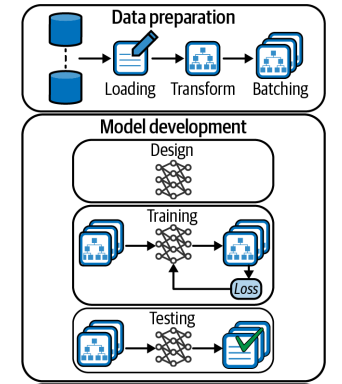

<ul>
    <li>Dataset : a. The Dataset class defines how to access and
preprocess data from a file or data sources.</li>
    <li>Sampler : The Sampler class
defines how to sample data from a dataset in order to create
batches</li>
    <li>DataLoader : DataLoader class combines a dataset with a
sampler and allows you to iterate over a set of batches.</li>
    
</ul>

In [2]:
def plot_current(dataframe):
    fig = plt.figure(figsize=(8,5))
    plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,1],c='r')
    plt.xlabel("time (mS)")
    plt.ylabel("current(pA)")
    plt.grid()
    plt.title("current diagram")
    plt.show()

In [3]:
sine_df = pd.read_csv("./datasets/sine_current.csv")
sine_df

time(mS)  current(pA)
0       0.03125  2328.112285
1       0.06250  2406.148295
2       0.09375  2484.031828
3       0.12500  2561.686833
4       0.15625  2639.037482
...         ...          ...
3195   99.87500   725.189542
3196   99.90625   787.834861
3197   99.93750   851.907960
3198   99.96875   917.346272
3199  100.00000   984.085897

[3200 rows x 2 columns]

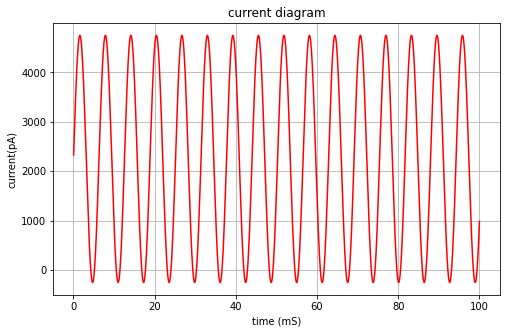

In [4]:
plot_current(sine_df)

In [5]:
const_df = pd.read_csv("./datasets/const_current.csv")
const_df

time(ms)  current(pA)
0       0.03125         4000
1       0.06250         4000
2       0.09375         4000
3       0.12500         4000
4       0.15625         4000
...         ...          ...
3195   99.87500         4000
3196   99.90625         4000
3197   99.93750         4000
3198   99.96875         4000
3199  100.00000         4000

[3200 rows x 2 columns]

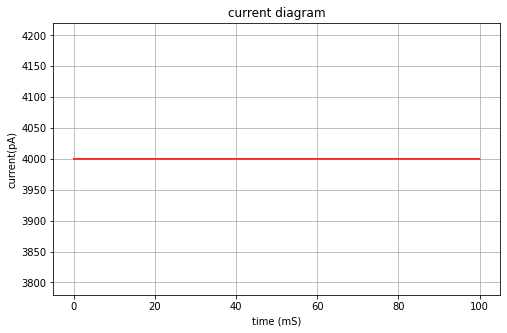

In [6]:
plot_current(const_df)

In [7]:
random_df = pd.read_csv("./datasets/random_current.csv")
random_df

time(mS)   current(pA)
0       0.03125      0.000000
1       0.06250  11043.525833
2       0.09375      0.000000
3       0.12500      0.000000
4       0.15625   8088.513623
...         ...           ...
3195   99.87500      0.000000
3196   99.90625      0.000000
3197   99.93750      0.000000
3198   99.96875      0.000000
3199  100.00000      0.000000

[3200 rows x 2 columns]

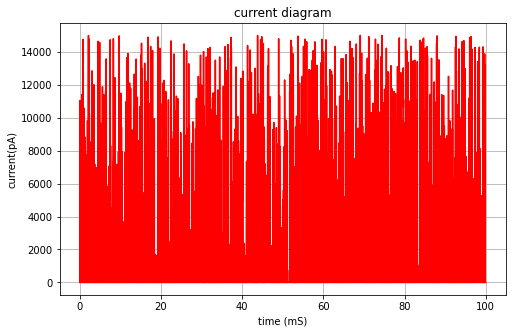

In [8]:
plot_current(random_df)

In [9]:
linear_df = pd.read_csv("./datasets/linear_current.csv")
linear_df

time(mS)  current(pA)
0       0.03125   3501.09375
1       0.06250   3502.18750
2       0.09375   3503.28125
3       0.12500   3504.37500
4       0.15625   3505.46875
...         ...          ...
3195   99.87500   6995.62500
3196   99.90625   6996.71875
3197   99.93750   6997.81250
3198   99.96875   6998.90625
3199  100.00000   7000.00000

[3200 rows x 2 columns]

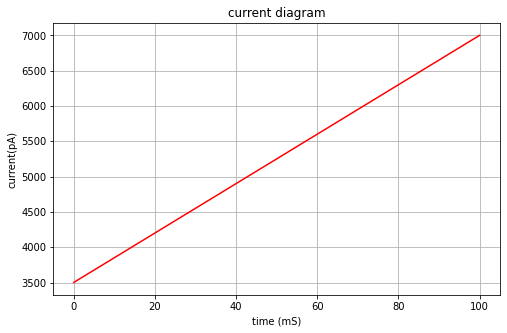

In [10]:
plot_current(linear_df)

In [18]:
class CurrentDataset(torch.utils.data.Dataset):
    """current dataset"""

    def __init__(self,file_path):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.file_path = file_path
        self.data = pd.read_csv(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[idx].values
        return torch.tensor(sample)

In [15]:
class LIF(torch.nn.Module):
    """
    Leaky Integrate and Fire model for neuron dynamic
    """
    
    def __init__(self,R,tau,u_rest,threshold):
        """
        Args:
            R : Circuit resistance equivalent to neuron gates (MΩ)
            tau : Time constant of the neuron (mS)
            u_rest : Resting potential of the neuron (mV)
            threshold : spiking threshold of the neuron (mV)
        """
        super(LIF, self).__init__()
        self.R=R
        self.tau=tau
        self.u=u_rest
        self.u_rest=u_rest
        self.threshold=threshold
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
    
    def forward(self,x):
        dt = x[0] - self.time
        self.time = x[0]
        du=dt*(-1*(self.u-self.u_rest)+self.R*x[1])/self.tau
        self.u +=du
        if self.u>self.threshold:
            self.to_rest()
            self.history = torch.vstack((self.history,torch.tensor([self.time,self.u])))
            return torch.tensor([[self.time,1]])
        else : 
            self.history = torch.vstack((self.history,torch.tensor([self.time,self.u])))
            return torch.tensor([[self.time,0]])
        
    def reset(self):
        self.u=self.u_rest
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
        
    
    def to_rest(self):
        self.u=self.u_rest

In [11]:
def process(model,dataloader):
    spikes_data =None 
    for data in dataloader:
        result = model(data[0])
        if spikes_data is None:
            spikes_data = result
        else : 
            spikes_data = torch.vstack((spikes_data,result))
    return spikes_data

In [12]:
def plot_spikes(spikes):
    spike_points = spikes[spikes[:,1]==1.0]
    fig = plt.figure(figsize=(10,5))
    plt.scatter(spike_points[:,0],spike_points[:,1],marker='|',c='r',s=500)
    plt.xlabel("time (mS)")
    plt.yticks(ticks=[1],labels=['spike'])
    plt.grid()
    plt.title("Spike points diagram")
    plt.show()

In [13]:
def plot_history(history):
    fig = plt.figure(figsize=(8,5))
    plt.plot(history[:,0],history[:,1],c='r')
    plt.xlabel("time (mS)")
    plt.ylabel("Voltage(mV)")
    plt.grid()
    plt.title("PSP diagram")
    plt.show()

In [16]:
# Initializing LIF model
# R(MΩ)
R = 0.01 
# tau (mS)
tau = 8
# u_rest (mV)
u_rest = -65
# threshold (mV)
threshold = -50

model = LIF(R,tau,u_rest,threshold)

<h2>Linear current</h2>

In [19]:
# create dataset and data loader for linear current dataset
path = os.path.join(os.path.abspath(os.curdir),'./datasets/linear_current.csv')
linear_current_dataset = CurrentDataset(path)
linear_current_dataloader = torch.utils.data.DataLoader(linear_current_dataset,batch_size=1,shuffle=False)

In [20]:
spikes_information = process(model,linear_current_dataloader)

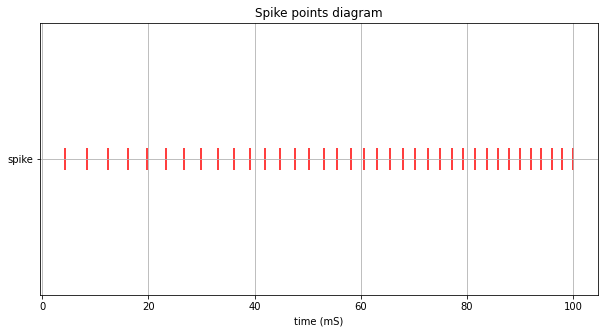

In [21]:
plot_spikes(spikes_information)

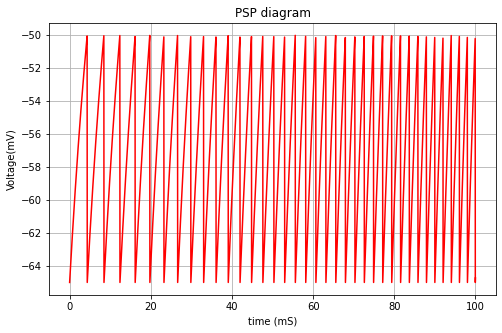

In [22]:
plot_history(model.history)

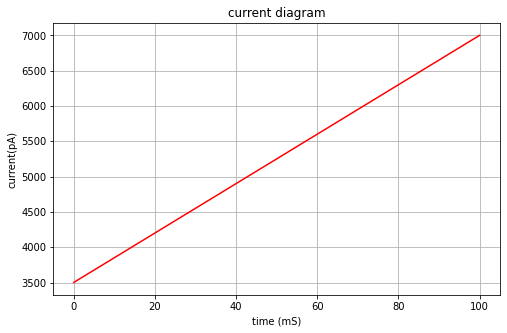

In [23]:
plot_current(linear_df)

In [24]:
model.reset()

<h2>Sine current</h2>

In [25]:
# create dataset and data loader for sine current dataset
path = os.path.join(os.path.abspath(os.curdir),'./datasets/sine_current.csv')
sine_current_dataset = CurrentDataset(path)
sine_current_dataloader = torch.utils.data.DataLoader(sine_current_dataset,batch_size=1,shuffle=False)

In [26]:
spikes_information = process(model,sine_current_dataloader)

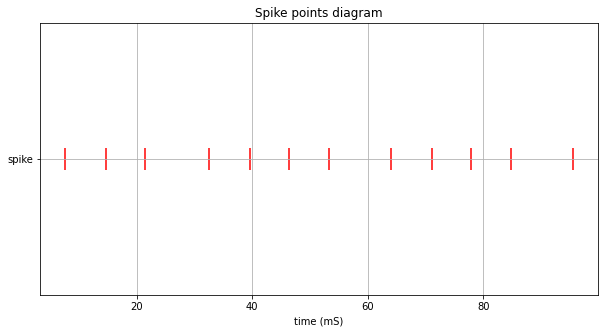

In [27]:
plot_spikes(spikes_information)

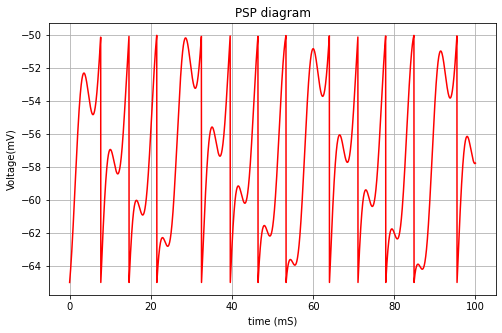

In [28]:
plot_history(model.history)

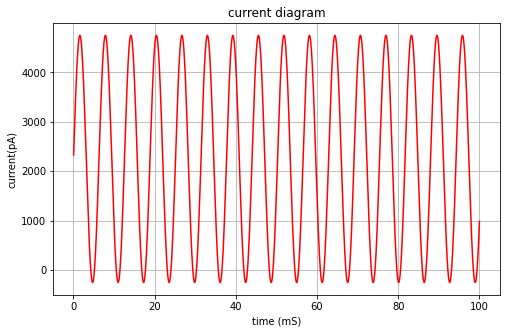

In [29]:
plot_current(sine_df)

In [30]:
model.reset()

<h2>Random current<h2/>

In [31]:
# create dataset and data loader for sine random dataset
path = os.path.join(os.path.abspath(os.curdir),'./datasets/random_current.csv')
random_current_dataset = CurrentDataset(path)
random_current_dataloader = torch.utils.data.DataLoader(random_current_dataset,batch_size=1,shuffle=False)

In [32]:
spikes_information = process(model,random_current_dataloader)

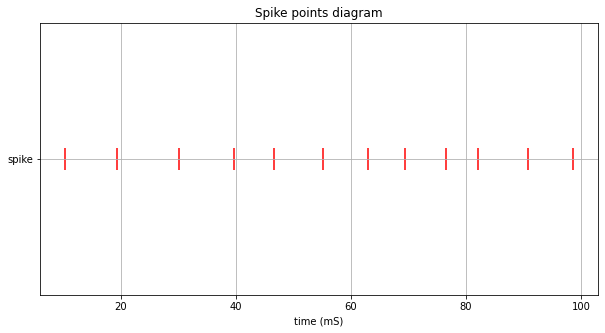

In [33]:
plot_spikes(spikes_information)

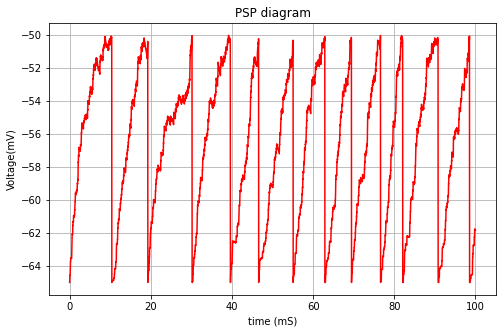

In [34]:
plot_history(model.history)

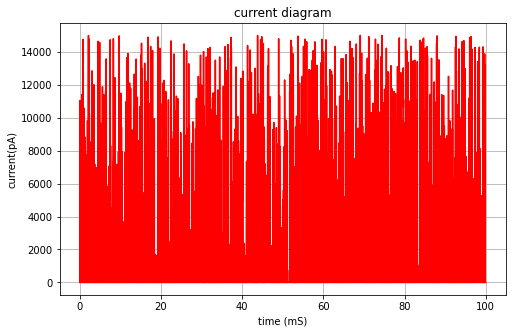

In [35]:
plot_current(random_df)

In [36]:
model.reset()

<h2>Const current</h2>

In [37]:
# create dataset and data loader for const random dataset
path = os.path.join(os.path.abspath(os.curdir),'./datasets/const_current.csv')
const_current_dataset = CurrentDataset(path)
const_current_dataloader = torch.utils.data.DataLoader(const_current_dataset,batch_size=1,shuffle=False)

In [38]:
spikes_information = process(model,const_current_dataloader)

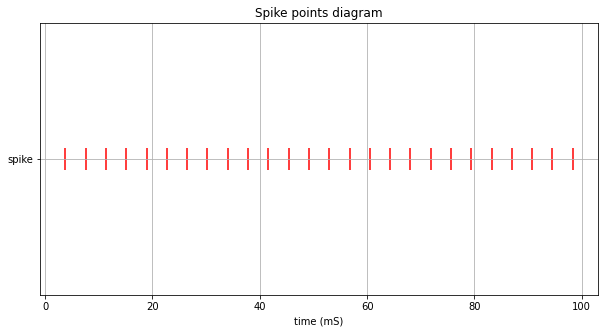

In [39]:
plot_spikes(spikes_information)

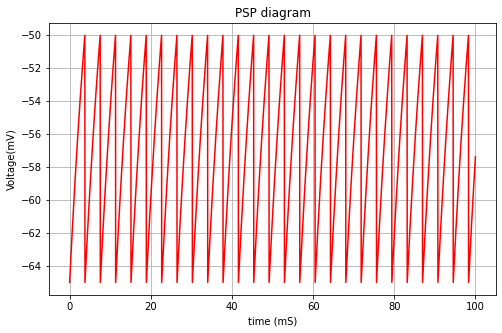

In [40]:
plot_history(model.history)

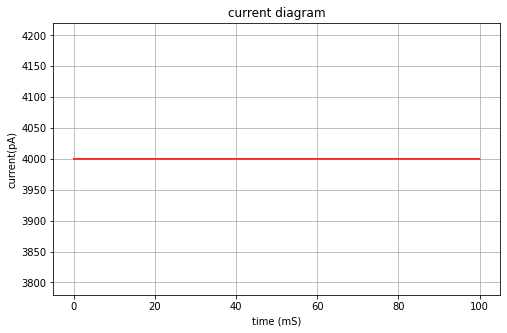

In [41]:
plot_current(const_df)